<a href="https://colab.research.google.com/github/hasanzeynal/TensorFlow-Developer-Certificate/blob/main/03_CNN_and_Computer_Vision/computer_vision_and_cnn_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import random
import os

from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, precision_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
#ignore all warnings
import warnings
warnings.filterwarnings(action= 'ignore')

# Introduction to CNN and Computer Vision
What we are gonna cover:
* Getting a DataSet for working on it(pizza_steak)
* Architecture of Convolutional Neural Network(CNN) in TensorFlow
* An end-to-end Binary Classification Problem
* Steps in Modelling with CNNs
* Creating a CNN model, compiling, fitting, and evaluating it
* An End-to-end Multiclass Classification Problem
* Making Predictions on Own Custom Images

# Importing Data for working on it(Pizza-Steak Images)

In [3]:
#get the data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

#unzip the downloaded file
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-02 10:13:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.2’

pizza_steak.zip.2   100%[===================>] 104.47M  33.6MB/s    in 3.1s    

2023-07-02 10:13:48 (33.6 MB/s) - ‘pizza_steak.zip.2’ saved [109540975/109540975]



## Inspect the dataset (means become one with it)

In [4]:
!ls pizza_steak

test  train


In [5]:
!ls pizza_steak/train

pizza  steak


In [6]:
!ls pizza_steak/train/pizza

1008104.jpg  1638227.jpg  2235981.jpg  2774899.jpg  3464027.jpg  576236.jpg
1008144.jpg  1646974.jpg  2236914.jpg  2775763.jpg  3464858.jpg  5764.jpg
1008844.jpg  1649108.jpg  2241448.jpg  2778214.jpg  3473991.jpg  579691.jpg
1008941.jpg  1649276.jpg  2247711.jpg  277963.jpg   3475936.jpg  593400.jpg
1011404.jpg  1652943.jpg  2253670.jpg  2785084.jpg  3478964.jpg  59445.jpg
102037.jpg   1654444.jpg  2255361.jpg  2793535.jpg  3479875.jpg  596494.jpg
1026922.jpg  1660415.jpg  2274117.jpg  27963.jpg    3479936.jpg  598381.jpg
1029698.jpg  1663749.jpg  2279642.jpg  2800325.jpg  3484590.jpg  604977.jpg
1033251.jpg  1665654.jpg  2280345.jpg  2811032.jpg  3493457.jpg  608085.jpg
1035854.jpg  166823.jpg   2285269.jpg  282013.jpg   349946.jpg	 618021.jpg
1038357.jpg  1670471.jpg  2285942.jpg  2821034.jpg  350358.jpg	 61822.jpg
1040878.jpg  1671531.jpg  228778.jpg   2821048.jpg  3505182.jpg  618348.jpg
1044524.jpg  1678284.jpg  2291093.jpg  2827938.jpg  3512070.jpg  625687.jpg
1044789.jpg  16810

In [7]:
#let's walk on data
for i, j, k in os.walk('/content/pizza_steak'):
  print(f"There are {len(j)} directories and  {len(k)} images in '{i}'")

There are 2 directories and  0 images in '/content/pizza_steak'
There are 2 directories and  0 images in '/content/pizza_steak/train'
There are 0 directories and  750 images in '/content/pizza_steak/train/steak'
There are 0 directories and  750 images in '/content/pizza_steak/train/pizza'
There are 2 directories and  0 images in '/content/pizza_steak/test'
There are 0 directories and  250 images in '/content/pizza_steak/test/steak'
There are 0 directories and  250 images in '/content/pizza_steak/test/pizza'


## To visualize our data, let's get the class names programmatically

In [8]:
#getting class names programmaticaly
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [9]:
#let's visualize random image
def view_random_image(target_dir, target_class):   #target_dir means train or test, target_class means steak or pizza
  target_folder = 'pizza_steak/' + target_dir + '/' + target_class
  random_image = random.sample(os.listdir(target_folder), 1)[0]
  target = target_folder + '/' + random_image
  read_img = mpimg.imread(target)
  img = plt.imshow(read_img)
  plt.title(target_class)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  return img

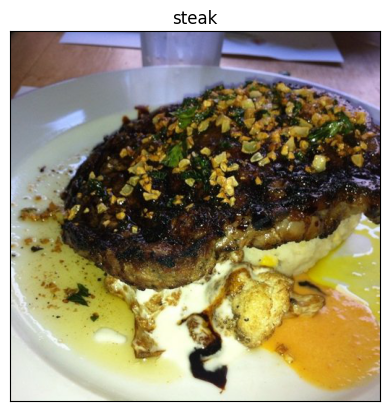

In [10]:
#get the steak images randomly
view_random_image(target_dir= 'test',
                  target_class= 'steak')

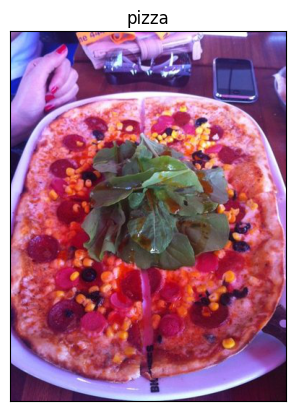

In [11]:
#get the pizza images randomly
view_random_image(target_dir= 'train',
                  target_class= 'pizza')

#Building models
Some kind of different models architecture can be used for this binary classification problem and we will have look at all of them to figure out which type of model would be best fit our model.
* Non CNN models (Dense layers)
* CNN Models (Conv2d, Flatten, MaxPool, AvgPool layers)
* Improved Nonn CNN and CNN models


## Non CNN Model

In [12]:
#let's preproccess our images to the numerical data with same shapes(224,224,3)

#set the train and test directories
train_dir = 'pizza_steak/train'
test_dir = 'pizza_steak/test'

#create instance of ImageDataGenerator
train_gen = ImageDataGenerator(rescale = 1./256)
test_gen = ImageDataGenerator(rescale = 1./256)

#flow images from specified directory and apply data augmendation
train_data = train_gen.flow_from_directory(directory= train_dir,
                                           batch_size=32,
                                           target_size=(224, 224),
                                           class_mode='binary',
                                           seed=42)

test_data = test_gen.flow_from_directory(directory= test_dir,
                                         batch_size= 32,
                                         target_size= (224, 224),
                                         class_mode= 'binary',
                                         seed = 42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [13]:
#let's create first simple model which is not cnn architecture(simple fully connected layers-Dense)

#set the random seed
tf.random.set_seed(42)

#create model
non_cnn_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape= (224, 224, 3)),
    tf.keras.layers.Dense(5, activation= 'relu'),
    tf.keras.layers.Dense(5, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

#compile the model
non_cnn_model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                        optimizer = 'adam',
                        metrics = ['accuracy'])

#fit the model
non_cnn_model_1_history = non_cnn_model_1.fit(train_data,
                                              epochs= 5,
                                              steps_per_epoch= len(train_data),
                                              validation_data= test_data,
                                              validation_steps= len(test_data))

Epoch 1/5
47/47 [==============================] - 13s 229ms/step - loss: 0.8112 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 11s 239ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 10s 214ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 10s 213ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 13s 281ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [14]:
#get the summary
non_cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 5)                 752645    
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 752,681
Trainable params: 752,681
Non-trainable params: 0
_________________________________________________________________


In [39]:
#get the plots for accuracy score and loss on both of train and validation subb sets
def view_plots(history):
  plt.figure(figsize=(16, 9))
  #get the accuracy plot
  fig_1 = pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
  #get the loss plot
  fig_2 = pd.DataFrame(history.history)[['loss','val_loss']].plot()
  plt.show()
  return fig_1, fig_2

<Figure size 1600x900 with 0 Axes>

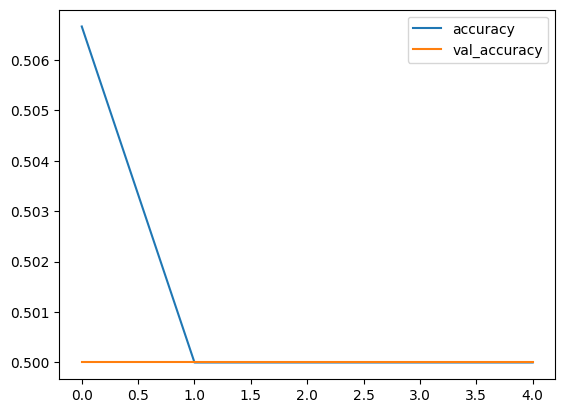

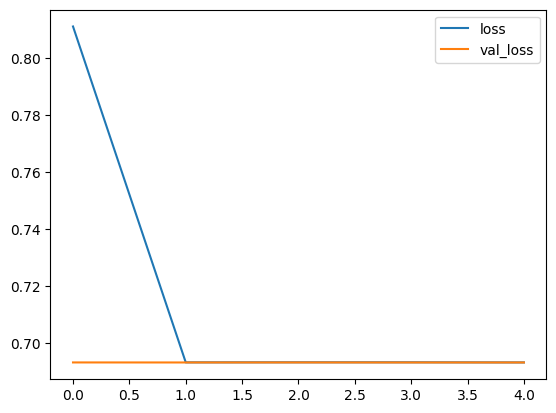

(<Axes: >, <Axes: >)

In [40]:
view_plots(non_cnn_model_1.history)

## Non CNN Model 2

In [43]:
#let's create second model with full connected layers

#set the seed
tf.random.set_seed(42)

#create the model
non_cnn_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape= (224, 224, 3)),
    tf.keras.layers.Dense(100, activation= 'relu'),    #number of units per hidden layer is increased to 100
    tf.keras.layers.Dense(100, activation= 'relu'),
    tf.keras.layers.Dense(100, activation= 'relu'),    #adding more hidden layer
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

#compile the model
non_cnn_model_2.compile(loss = 'binary_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(lr = 0.001),
                        metrics = ['accuracy'])

#fit the model
non_cnn_model_2_history = non_cnn_model_2.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch= len(train_data),
                                              validation_data = test_data,
                                              validation_steps= len(test_data))

Epoch 1/5
47/47 [==============================] - 12s 217ms/step - loss: 2.9419 - accuracy: 0.6167 - val_loss: 1.1080 - val_accuracy: 0.6780
Epoch 2/5
47/47 [==============================] - 10s 223ms/step - loss: 1.3413 - accuracy: 0.6840 - val_loss: 0.9876 - val_accuracy: 0.7160
Epoch 3/5
47/47 [==============================] - 10s 220ms/step - loss: 0.9544 - accuracy: 0.7253 - val_loss: 0.6786 - val_accuracy: 0.7800
Epoch 4/5
47/47 [==============================] - 10s 220ms/step - loss: 0.8614 - accuracy: 0.7533 - val_loss: 0.6144 - val_accuracy: 0.7420
Epoch 5/5
47/47 [==============================] - 12s 262ms/step - loss: 0.6190 - accuracy: 0.7640 - val_loss: 0.6492 - val_accuracy: 0.7180


In [44]:
#get the summary for the second layer
non_cnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_5 (Dense)             (None, 100)               15052900  
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


<Figure size 1600x900 with 0 Axes>

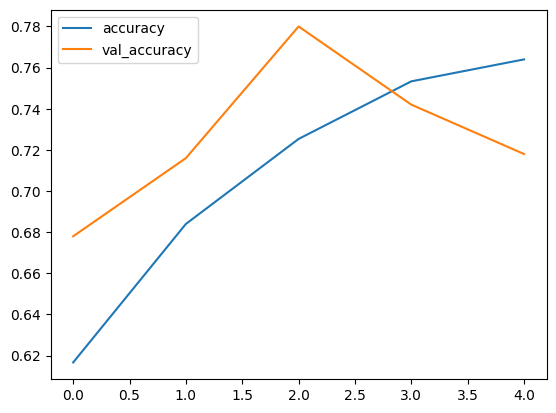

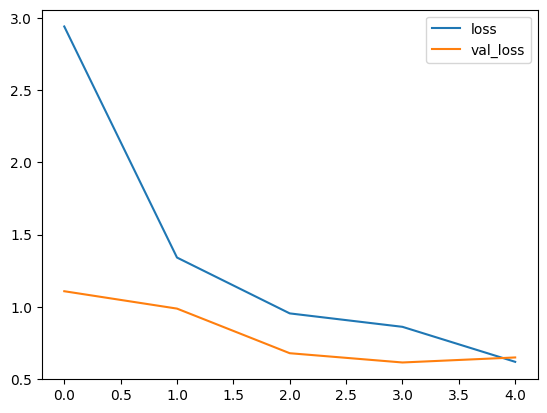

(<Axes: >, <Axes: >)

In [45]:
view_plots(non_cnn_model_2_history)

## CNN Model 1

In [13]:
#let's create the cnn model 1 and it is gonna be a little bit small and simple

#set the random_state
tf.random.set_seed(42)

#